In [1]:
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SCORED_PATH = "../output/stack_overflow_bs200_dl02_lr005_lstm128_fc256_glove/scored/scored_output.csv"

In [3]:
scores_df = pd.read_csv(SCORED_PATH)

In [4]:
proba_scores = scores_df.loc[:, scores_df.columns.str.startswith('proba_')].values

In [5]:
kmeans = KMeans(n_clusters=proba_scores.shape[1] + 1, random_state=0)
kmeans.fit(proba_scores)

KMeans(n_clusters=6, random_state=0)

In [6]:
clusters = kmeans.predict(proba_scores).reshape((-1, 1))

In [7]:
tsne_xy = TSNE(n_components=2).fit_transform(proba_scores)

In [8]:
visualize_df = pd.DataFrame(
    np.concatenate((tsne_xy, clusters), axis=1), columns=['tsne_1', 'tsne_2', 'cluster_id'])

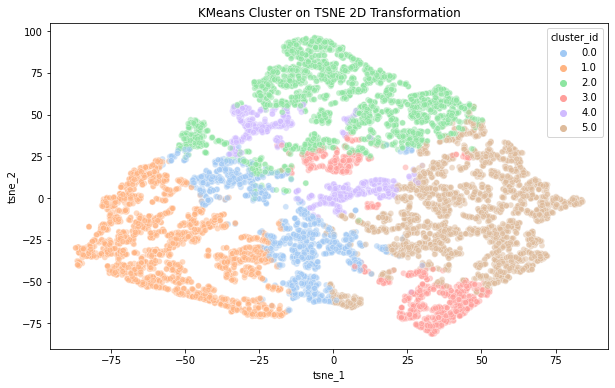

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visualize_df,x='tsne_1',y='tsne_2',hue='cluster_id',
                legend="full",alpha=0.5, palette='pastel')
plt.title("KMeans Cluster on TSNE 2D Transformation")
plt.show()

In [11]:
scores_df['cluster_id'] = clusters

In [19]:
SAMPLE_SIZE  = 20
group_sample_n = SAMPLE_SIZE // scores_df.cluster_id.nunique()
sample_df = scores_df.groupby('cluster_id').apply(lambda x: x.sample(n = group_sample_n)).reset_index(drop=True)

In [27]:
unsampled_count = SAMPLE_SIZE - sample_df.shape[0]
if unsampled_count > 0:
    unsampled_ids = scores_df.UID[~np.isin(scores_df.UID, sample_df.UID)]
    additional_ids = np.random.choice(unsampled_ids, unsampled_count, replace=False)

In [32]:
additional_df = scores_df.loc[np.isin(scores_df.UID, additional_ids), :]
sample_df = pd.concat([sample_df, additional_df], ignore_index=True)

In [46]:
def kmeans_from_proba(scored_df, tsne_fig_name, score_col_prefix='proba_', random_state=0):
    print("Extracting tag scores and training KMeans for clusters")
    # extract tag scores into np.array
    proba_scores = scored_df.loc[:, scored_df.columns.str.startswith(score_col_prefix)].values
    # fit and extract kmeans clusters
    kmeans = KMeans(n_clusters=proba_scores.shape[1] + 1, random_state=random_state)
    kmeans.fit(proba_scores)
    clusters = kmeans.predict(proba_scores).reshape((-1, 1))
    print("Visualizing tag score-based KMeans clusters with tSNE")
    # visualize the clusters using tsne
    tsne_xy = TSNE(n_components=2).fit_transform(proba_scores)
    visualize_df = pd.DataFrame(
        np.concatenate((tsne_xy, clusters), axis=1), columns=['tsne_1', 'tsne_2', 'cluster_id'])
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=visualize_df,x='tsne_1',y='tsne_2',hue='cluster_id',
                    legend="full",alpha=0.5, palette='pastel')
    plt.title("KMeans Cluster on TSNE 2D Transformation")
    plt.savefig(tsne_fig_name, bbox_inches='tight')
    plt.close()
    # save cluster info back to scored_df
    print("Saving cluster information back to dataframe")
    scored_df['cluster_id'] = clusters
    return scored_df


def sample_by_cluster(scored_df, sample_size, cluster_col='cluster_id', row_key='UID'):
    print("Sampling records based on cluster information...")
    group_sample_n = sample_size // scored_df[cluster_col].nunique()
    sample_df = scored_df.groupby(cluster_col).apply(lambda x: x.sample(n=group_sample_n)).reset_index(drop=True)
    unsampled_count = sample_size - sample_df.shape[0]
    print(f"A total of {sample_df.shape[0]:,} records were sampled based on clusters.")
    if unsampled_count > 0:
        print(f"{unsampled_count:,} remaining records are to be sampled from total population.")
        unsampled_ids = scored_df[row_key][~np.isin(scored_df.UID, sample_df.UID)]
        additional_ids = np.random.choice(unsampled_ids, unsampled_count, replace=False)
        additional_df = scored_df.loc[np.isin(scored_df[row_key], additional_ids), :]
        sample_df = pd.concat([sample_df, additional_df], ignore_index=True)
    return sample_df


def sample_by_random(scored_df, sample_size, cluster_col='cluster_id', row_key='UID'):
    print("Sampling records based on pure randomness...")
    print(f"{sample_size:,} records are to be sampled from total population.")
    sample_ids = np.random.choice(scored_df[row_key], sample_size, replace=False)
    sample_df = scored_df.loc[np.isin(scored_df[row_key], sample_ids), :].reset_index(drop=True)
    return sample_df

In [47]:
scores_df_test = kmeans_from_proba(scores_df, 'test_tsne.png')

Extracting tag scores and training KMeans for clusters
Visualizing tag score-based KMeans clusters with tSNE
Saving cluster information back to dataframe


In [55]:
clst_sample_df = sample_by_cluster(scores_df_test, 40)

Sampling records based on cluster information...
A total of 36 records were sampled based on clusters.
4 remaining records are to be sampled from total population.


In [56]:
random_sample_df = sample_by_random(scores_df_test, 40)

Sampling records based on pure randomness...
40 records are to be sampled from total population.


In [57]:
random_sample_df.cluster_id.value_counts()

4    10
1    10
5     9
3     4
2     4
0     3
Name: cluster_id, dtype: int64

In [58]:
clst_sample_df.cluster_id.value_counts()

4    9
1    7
5    6
3    6
2    6
0    6
Name: cluster_id, dtype: int64